In [1]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dataManager import DataManager
from maskPredictor import MaskPredictor


def datagen(video_path,nn_weights_path, batch_size=1, output_length=30):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = DataManager(video_path)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=30*output_length*60)
    nn_model = MaskPredictor(nn_weights_path)
    masks_generator = nn_model.get_mask_generator(frame_generator, th=0.7)

    areas = []

    for i, (mask, frame, source) in tqdm(enumerate(masks_generator)):
        # # contours
        contours = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)
        # mask = cv2.threshold(np.uint8(mask[:,:]*255), 210, 255, cv2.THRESH_BINARY)[1]
        # kernel = np.ones((9, 9), np.uint8)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)
        data = {'orig': source,
                'mask': mask,
                'contours':  contours}

        yield data

def visualizer(generator, savepath, output_length=0.5, fps=15, bitrate=1800):
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(4, 4)
    ax_orig = fig.add_subplot(gs[0:2, :2])
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_masks = fig.add_subplot(gs[2:, 0:2])
    ax_masks.set_title('Маска', fontsize=12)
    ax_contours = fig.add_subplot(gs[:2, 2:])
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_contours.axis('off')
    ax_orig.axis('off')
    ax_masks.axis('off')


    def updateData(data):
        keys = ['orig', 'mask',  'contours']
        orig, mask,   contours = [data[key] for key in keys]
        # original
        ax_orig.clear()
        ax_orig.set_title('Исходное изображение', fontsize=12)
        ax_orig.imshow(orig, aspect='auto')
        ax_orig.axis('off')

        # masks
        ax_masks.clear()
        ax_masks.set_title('Маска', fontsize=12)
        ax_masks.imshow(mask, cmap='gray', aspect='auto')
        ax_masks.axis('off')

        # # contours
        ax_contours.clear()
        ax_contours.set_title('Рассчитанные контуры', fontsize=12)
        ax_contours.imshow(contours, aspect='auto')
        ax_contours.axis('off')

    simulation = animation.FuncAnimation(fig, updateData, frames=generator, save_count=30*output_length*60)

    writer = animation.writers['ffmpeg'](fps=fps, bitrate=10000)
    simulation.save(savepath, writer=writer)


17it [00:11,  1.51it/s]

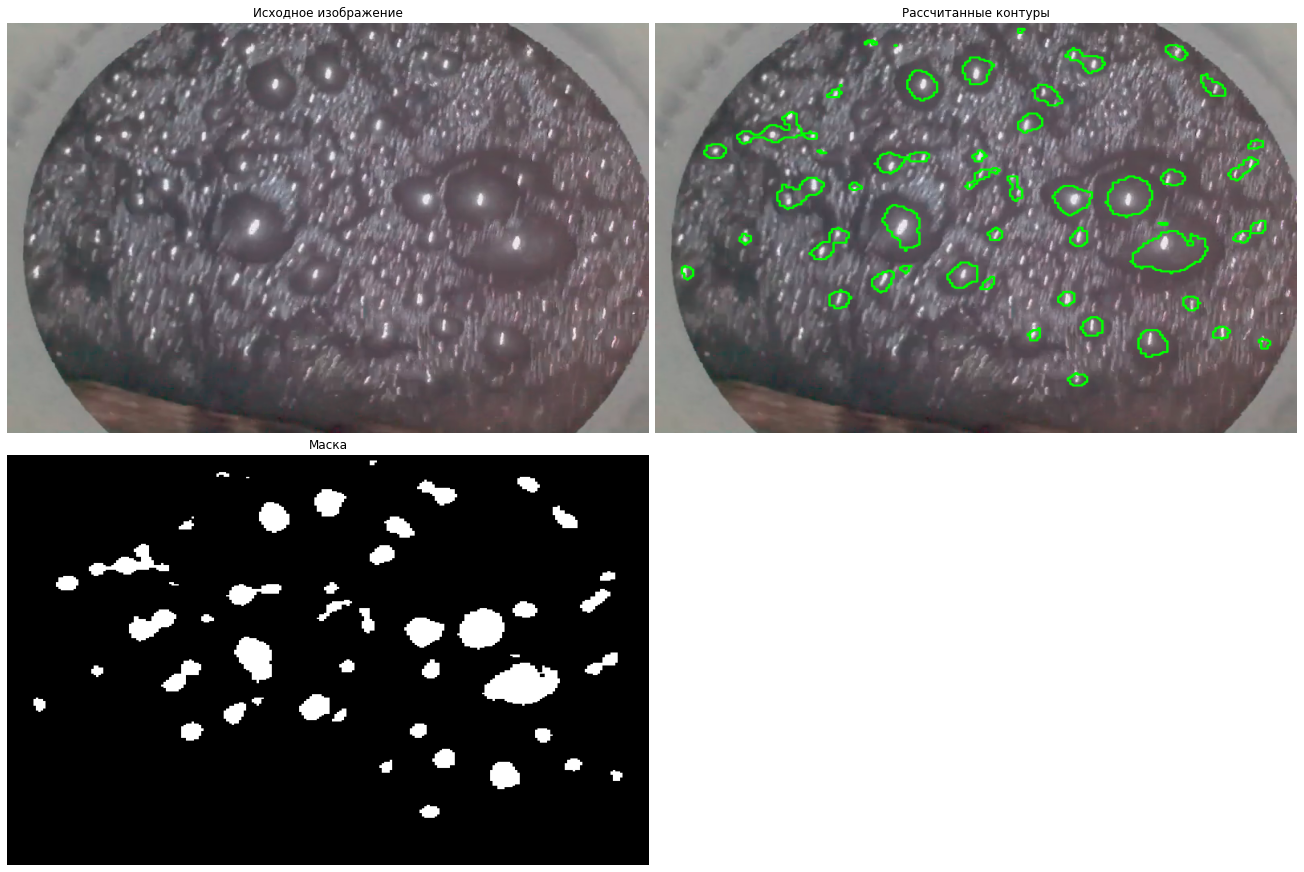

In [2]:
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen('data/90_1_7.mp4', 'weights/unetplusplus_weights.pt', batch_size=1)
visualizer(generator, './results/visualization.mp4', fps=15, output_length=0.01)